# Dictionary based clustering

In [82]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn import metrics
import numpy as np
import pandas as pd
import json
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.cluster import KMeansClusterer, cosine_distance
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')

In [83]:
import numpy as np
import pandas as pd

articles = pd.read_csv("articles2.csv")

articles = articles.drop(["Unnamed: 0"], axis = 1)

articles = articles.drop([0,1,2])

articles['Text'] = articles['Text'].str.replace('\n','')
articles['Text'] = articles['Text'].str.replace('AllowNot now','')
articles['Text'] = articles['Text'].str.replace('Add Comment','')

articles = articles[~(articles['Text']=="Never miss a great news story!Get instant notifications from Economic TimesYou can switch off notifications anytime using browser settings.")]
articles = articles[~(articles['Text']=="Find this comment offensive?Choose your reason below and click on the Report button. This will alert our moderators to take actionNameReason for reporting:Foul languageSlanderousInciting hatred against a certain community")]

In [84]:
corpus = []
idea = articles.iloc[:, 3:4]
for index, row in idea.iterrows():
    corpus.append(row['Text'])

In [85]:
keywords = articles["Keywords"]

In [86]:
articles.head()

,Year,Month,Title,Text,Keywords
3,2002,1,Coal ministry may extend verification deadline,the union coal ministry on tuesday said it was...,"['governments', 'failed', 'coal', 'noncore', '..."
4,2002,1,What 2002 has in store for India Inc,yashwant sinha harping on a 7 per cent growth ...,"['sector', 'companies', 'store', 'cii', 'expec..."
5,2002,1,Year to the ground,"6 jan: enron threatens to invoke lcs, guarante...","['dec', 'bank', 'ground', 'sept', 'jan', 'nov'..."
6,2002,1,EoIs for third tranche of ITDC hotels,the government on tuesday invited initial bids...,"['sale', 'itdc', 'tranche', 'eois', 'propertie..."
7,2002,1,Two-year transition period proposed after APM,the government has proposed a transition perio...,"['twoyear', 'sector', 'petroleum', 'system', '..."


In [87]:
keywords[0:1]

3    ['governments', 'failed', 'coal', 'noncore', '...
Name: Keywords, dtype: object

In [88]:
# Function to remove unwanted string in the tweet
def remove_unwanted_string(dataframe):
    new_record = []
    tweet_text = dataframe.apply(lambda x: str(x).split())
    for record in tweet_text:
        for text in record:
            if 'RT' in text or '@' in text or '#' in text:
                record.remove(text)
        
        new_record.append(' '.join(record))
    dataframe = new_record
    return dataframe

articles['Text'] = remove_unwanted_string(articles['Text'])
articles.head()

,Year,Month,Title,Text,Keywords
3,2002,1,Coal ministry may extend verification deadline,the union coal ministry on tuesday said it was...,"['governments', 'failed', 'coal', 'noncore', '..."
4,2002,1,What 2002 has in store for India Inc,yashwant sinha harping on a 7 per cent growth ...,"['sector', 'companies', 'store', 'cii', 'expec..."
5,2002,1,Year to the ground,"6 jan: enron threatens to invoke lcs, guarante...","['dec', 'bank', 'ground', 'sept', 'jan', 'nov'..."
6,2002,1,EoIs for third tranche of ITDC hotels,the government on tuesday invited initial bids...,"['sale', 'itdc', 'tranche', 'eois', 'propertie..."
7,2002,1,Two-year transition period proposed after APM,the government has proposed a transition perio...,"['twoyear', 'sector', 'petroleum', 'system', '..."


## i) Afinn

https://pypi.org/project/afinn/

In [89]:
from afinn import Afinn
afinn = Afinn()
afinn.score('This is utterly excellent!')

3.0

### Example i)

In [90]:
text = articles.iloc[0,3]
text

'the union coal ministry on tuesday said it was likely to further extend the year-end deadline for verification of non-core customers. "we may have to further extend the december 31,2001 deadline set for state governments to verify linked non-core customers due to a poor response from certain state governments," coal secretary n k sinha said. sinha said the government would further extend deadline by fortnight to one month to enable erring states to complete verification exercise. the ministry had previuosly extended the deadline by one month starting november 30 after state governments failed to ensure verification of all such customers. the move to verify customers comes in the wake of complaints of massive black marketing of coal by diverting supplies from genuine customers to non-existent ones through bogus state sponsored linkages. while certain states like punjab have completed the exercise others namely, andhra pradesh, gujarat, jammu and kashmir, bihar and uttar pradesh have fa

In [91]:
afinn.score(text)

-6.0

### Example ii)

In [92]:
text = articles.iloc[1,3]
text

'yashwant sinha harping on a 7 per cent growth has become the worst cliche of 2001. india inc, however, is not so optimistic. the confederation of indian industry had an intensive, day-long brainstorming session to evaluate the corporate outlook for 2002. and this is what they came out with... 1. fiscal year 2001-02 will see a real gdp growth of no more than 5%. while this growth rate still makes india one of the faster growing countries of the world, it will be insufficient to create the demand stimulus needed for eliminating surplus capacities, raising corporate profits, generating higher tax revenue, and giving a much need impetus to fresh private sector investments. 2. the year 2002-03 is expected to be somewhat better. initial estimates of gdp growth are in the range of 5.5% to 6%. cii believes that the 4.5% growth in agricultural income in 2001-02 will contribute to a gradual turnaround in the manufacturing sector in the first half of 2002-03. this will, in all likelihood, be led

In [93]:
afinn.score(text)

49.0

In [94]:
articles['afinn_score'] = articles['Text'].apply(afinn.score)

In [95]:
articles.head(10)

,Year,Month,Title,Text,Keywords,afinn_score
3,2002,1,Coal ministry may extend verification deadline,the union coal ministry on tuesday said it was...,"['governments', 'failed', 'coal', 'noncore', '...",-6.0
4,2002,1,What 2002 has in store for India Inc,yashwant sinha harping on a 7 per cent growth ...,"['sector', 'companies', 'store', 'cii', 'expec...",49.0
5,2002,1,Year to the ground,"6 jan: enron threatens to invoke lcs, guarante...","['dec', 'bank', 'ground', 'sept', 'jan', 'nov'...",-51.0
6,2002,1,EoIs for third tranche of ITDC hotels,the government on tuesday invited initial bids...,"['sale', 'itdc', 'tranche', 'eois', 'propertie...",-1.0
7,2002,1,Two-year transition period proposed after APM,the government has proposed a transition perio...,"['twoyear', 'sector', 'petroleum', 'system', '...",10.0
8,2002,1,Govt updates commodity nomenclature,the government on tuesday updated commodity cl...,"['trade', 'updated', 'updates', 'commodity', '...",7.0
12,2002,1,Revamped HSN comes into force,the updated 2002 version of the harmonised sys...,"['version', 'trade', 'updated', 'system', 'tar...",8.0
13,2002,1,ONGC to revise bid for Panna-Mukta,oil and natural gas corporation is likely to i...,"['ongc', 'offer', 'gas', 'bid', 'british', 'ce...",-1.0
14,2002,1,Divestment: surviving political controversies ...,"facing an onslaught of charges and opposition,...","['2001', 'privatisation', 'minister', 'survivi...",-4.0
15,2002,1,Focus on rural development in 10th Plan,more emphasis would be laid on rural developme...,"['infrastructure', 'creating', '10th', 'rural'...",6.0


In [96]:
articles['afinn_score'].describe()

count    25070.000000
mean         9.629198
std         21.849476
min       -165.000000
25%          1.000000
50%          7.000000
75%         16.000000
max        709.000000
Name: afinn_score, dtype: float64

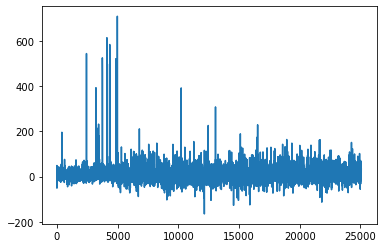

In [97]:
# Afinn score distribution
import matplotlib.pyplot as plt
plt.plot(articles['afinn_score'].tolist())

# ii) Vader
https://pypi.org/project/vaderSentiment/

In [98]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import pandas as pd

In [99]:
articles.head()

,Year,Month,Title,Text,Keywords,afinn_score
3,2002,1,Coal ministry may extend verification deadline,the union coal ministry on tuesday said it was...,"['governments', 'failed', 'coal', 'noncore', '...",-6.0
4,2002,1,What 2002 has in store for India Inc,yashwant sinha harping on a 7 per cent growth ...,"['sector', 'companies', 'store', 'cii', 'expec...",49.0
5,2002,1,Year to the ground,"6 jan: enron threatens to invoke lcs, guarante...","['dec', 'bank', 'ground', 'sept', 'jan', 'nov'...",-51.0
6,2002,1,EoIs for third tranche of ITDC hotels,the government on tuesday invited initial bids...,"['sale', 'itdc', 'tranche', 'eois', 'propertie...",-1.0
7,2002,1,Two-year transition period proposed after APM,the government has proposed a transition perio...,"['twoyear', 'sector', 'petroleum', 'system', '...",10.0


In [100]:
def sentiment_scores(sentence):
    """
    Create a SentimentIntensityAnalyzer object. 
    polarity_scores() method of SentimentIntensityAnalyzer.
    object gives a sentiment dictionary
    which contains pos, neg, neu, and compoind scores
    """
    sid_obj = SentimentIntensityAnalyzer() 
    sentiment_dict = sid_obj.polarity_scores(sentence)
    
    return sentiment_dict

In [101]:
text = articles.iloc[0,3]
sentiment_scores(text)

{'neg': 0.081, 'neu': 0.849, 'pos': 0.07, 'compound': -0.6898}

In [102]:
text = articles.iloc[1,3]
sentiment_scores(text)

{'neg': 0.037, 'neu': 0.858, 'pos': 0.104, 'compound': 0.9951}

In [103]:
pos, neg, neu, comp = [], [], [], []
for text in articles['Text']:
    sentiment = sentiment_scores(text)
    pos.append(sentiment['pos'])
    neg.append(sentiment['neg'])
    neu.append(sentiment['neu'])
    comp.append(sentiment['compound'])
    
# df_tweets_sentiment.columns = ['tweet_text', 'positive', 'negative', 'neutral', 'compound']
articles['vader_positive'] = pos
articles['Vader_negative'] = neg
articles['vader_neutral'] = neu
articles['vader_compound'] = comp

In [104]:
articles.head(10)

,Year,Month,Title,Text,Keywords,afinn_score,vader_positive,Vader_negative,vader_neutral,vader_compound
3,2002,1,Coal ministry may extend verification deadline,the union coal ministry on tuesday said it was...,"['governments', 'failed', 'coal', 'noncore', '...",-6.0,0.070,0.081,0.849,-0.6898
4,2002,1,What 2002 has in store for India Inc,yashwant sinha harping on a 7 per cent growth ...,"['sector', 'companies', 'store', 'cii', 'expec...",49.0,0.104,0.037,0.858,0.9951
5,2002,1,Year to the ground,"6 jan: enron threatens to invoke lcs, guarante...","['dec', 'bank', 'ground', 'sept', 'jan', 'nov'...",-51.0,0.081,0.136,0.783,-0.9987
6,2002,1,EoIs for third tranche of ITDC hotels,the government on tuesday invited initial bids...,"['sale', 'itdc', 'tranche', 'eois', 'propertie...",-1.0,0.014,0.027,0.959,-0.5859
7,2002,1,Two-year transition period proposed after APM,the government has proposed a transition perio...,"['twoyear', 'sector', 'petroleum', 'system', '...",10.0,0.061,0.009,0.930,0.9643
8,2002,1,Govt updates commodity nomenclature,the government on tuesday updated commodity cl...,"['trade', 'updated', 'updates', 'commodity', '...",7.0,0.080,0.009,0.911,0.9231
12,2002,1,Revamped HSN comes into force,the updated 2002 version of the harmonised sys...,"['version', 'trade', 'updated', 'system', 'tar...",8.0,0.057,0.009,0.933,0.9413
13,2002,1,ONGC to revise bid for Panna-Mukta,oil and natural gas corporation is likely to i...,"['ongc', 'offer', 'gas', 'bid', 'british', 'ce...",-1.0,0.068,0.047,0.886,0.8121
14,2002,1,Divestment: surviving political controversies ...,"facing an onslaught of charges and opposition,...","['2001', 'privatisation', 'minister', 'survivi...",-4.0,0.072,0.054,0.873,0.8176
15,2002,1,Focus on rural development in 10th Plan,more emphasis would be laid on rural developme...,"['infrastructure', 'creating', '10th', 'rural'...",6.0,0.129,0.048,0.823,0.9360


In [105]:
articles['vader_compound'].describe()

count    25070.000000
mean         0.594339
std          0.607925
min         -0.999800
25%          0.526700
50%          0.908100
75%          0.974900
max          1.000000
Name: vader_compound, dtype: float64

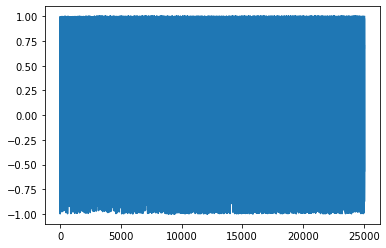

In [106]:
import matplotlib.pyplot as plt
plt.plot(articles['vader_compound'].tolist())

# iii) Vader + LM

In [107]:
import json
import nltk
import pickle
import pprint
import re

from tqdm import tqdm

articles.head()

,Year,Month,Title,Text,Keywords,afinn_score,vader_positive,Vader_negative,vader_neutral,vader_compound
3,2002,1,Coal ministry may extend verification deadline,the union coal ministry on tuesday said it was...,"['governments', 'failed', 'coal', 'noncore', '...",-6.0,0.070,0.081,0.849,-0.6898
4,2002,1,What 2002 has in store for India Inc,yashwant sinha harping on a 7 per cent growth ...,"['sector', 'companies', 'store', 'cii', 'expec...",49.0,0.104,0.037,0.858,0.9951
5,2002,1,Year to the ground,"6 jan: enron threatens to invoke lcs, guarante...","['dec', 'bank', 'ground', 'sept', 'jan', 'nov'...",-51.0,0.081,0.136,0.783,-0.9987
6,2002,1,EoIs for third tranche of ITDC hotels,the government on tuesday invited initial bids...,"['sale', 'itdc', 'tranche', 'eois', 'propertie...",-1.0,0.014,0.027,0.959,-0.5859
7,2002,1,Two-year transition period proposed after APM,the government has proposed a transition perio...,"['twoyear', 'sector', 'petroleum', 'system', '...",10.0,0.061,0.009,0.930,0.9643


In [108]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nrjkh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nrjkh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [109]:
from nltk.corpus import stopwords

wnl = nltk.stem.WordNetLemmatizer()

lemma_english_stopwords = [wnl.lemmatize(x) for x in stopwords.words('english')]

def preprocess(paragraphs):
#     message = ' '.join(paragraphs)
    
    # Lowercase the message
    text = paragraphs.lower()
    
    # Replace everything not a letter with a space
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    
    # Tokenize by splitting the string on whitespace into a list of words
    tokens = text.split()

    # Lemmatize wotwo corpora: the stopwords corpus for removing stopwords and wordnet for lemmatizing.

    wnl = nltk.stem.WordNetLemmatizer()
    tokens = [wnl.lemmatize(x) for x in tokens if len(x)>1]
    tokens = [x for x in tokens if x not in lemma_english_stopwords]
    
    return tokens

In [110]:
articles.head()

,Year,Month,Title,Text,Keywords,afinn_score,vader_positive,Vader_negative,vader_neutral,vader_compound
3,2002,1,Coal ministry may extend verification deadline,the union coal ministry on tuesday said it was...,"['governments', 'failed', 'coal', 'noncore', '...",-6.0,0.070,0.081,0.849,-0.6898
4,2002,1,What 2002 has in store for India Inc,yashwant sinha harping on a 7 per cent growth ...,"['sector', 'companies', 'store', 'cii', 'expec...",49.0,0.104,0.037,0.858,0.9951
5,2002,1,Year to the ground,"6 jan: enron threatens to invoke lcs, guarante...","['dec', 'bank', 'ground', 'sept', 'jan', 'nov'...",-51.0,0.081,0.136,0.783,-0.9987
6,2002,1,EoIs for third tranche of ITDC hotels,the government on tuesday invited initial bids...,"['sale', 'itdc', 'tranche', 'eois', 'propertie...",-1.0,0.014,0.027,0.959,-0.5859
7,2002,1,Two-year transition period proposed after APM,the government has proposed a transition perio...,"['twoyear', 'sector', 'petroleum', 'system', '...",10.0,0.061,0.009,0.930,0.9643


In [111]:
articles["token"] = articles["Text"].apply(preprocess)

In [112]:
articles.head()

,Year,Month,Title,Text,Keywords,afinn_score,vader_positive,Vader_negative,vader_neutral,vader_compound,token
3,2002,1,Coal ministry may extend verification deadline,the union coal ministry on tuesday said it was...,"['governments', 'failed', 'coal', 'noncore', '...",-6.0,0.070,0.081,0.849,-0.6898,"[union, coal, ministry, tuesday, said, likely,..."
4,2002,1,What 2002 has in store for India Inc,yashwant sinha harping on a 7 per cent growth ...,"['sector', 'companies', 'store', 'cii', 'expec...",49.0,0.104,0.037,0.858,0.9951,"[yashwant, sinha, harping, per, cent, growth, ..."
5,2002,1,Year to the ground,"6 jan: enron threatens to invoke lcs, guarante...","['dec', 'bank', 'ground', 'sept', 'jan', 'nov'...",-51.0,0.081,0.136,0.783,-0.9987,"[jan, enron, threatens, invoke, lcs, guarantee..."
6,2002,1,EoIs for third tranche of ITDC hotels,the government on tuesday invited initial bids...,"['sale', 'itdc', 'tranche', 'eois', 'propertie...",-1.0,0.014,0.027,0.959,-0.5859,"[government, tuesday, invited, initial, bid, t..."
7,2002,1,Two-year transition period proposed after APM,the government has proposed a transition perio...,"['twoyear', 'sector', 'petroleum', 'system', '...",10.0,0.061,0.009,0.930,0.9643,"[government, proposed, transition, period, two..."


**Q)** Why do I tokenize data while using VADER? <br>
**Ans)** Since punctuation, capitalization and use of intensifiers are more rarely used in serious news articles than social media posts, I still lowered and lemmatized the words, so try to only rely on the words sentiment from this package.

## Analysis on News
### VaderSentiment
https://github.com/cjhutto/vaderSentiment#python-demo-and-code-examples

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.

Threshold values it used are:

* positive sentiment: compound score >= 0.05
* neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
* negative sentiment: compound score <= -0.05

VADER judges sentiment by

* Punctuation — I love pizza vs I love pizza!!
* Capitalization — I’m hungry!! vs I’M HUNGRY!!
* Degree modifiers (use of intensifiers)— I WANT TO EAT!! VS I REALLY WANT TO EAT!!
* Conjunctions (shift in sentiment polarity, with later dictating polarity) — I love pizza, but I really hate Pizza Hut (bad review)
* Preceding Tri-gram (identifying reverse polarity by examining the tri-gram before the lexical feature— Canadian Pizza is not really all that great.

VADER is focused on social media and short texts while Financial News are almost the opposite. So I update the VADER lexicon with words+sentiments from the Loughran-McDonald Financial Sentiment Word Lists.

## Loughran McDonald Sentiment Word Lists
data source: https://sraf.nd.edu/textual-analysis/resources/

Loughran McDonald Sentiment Word Lists categorizes words into the 7 sentiments. It's built using exclusively corporate disclosures.

* Negative
* Positive
* Uncertainty
* Litigious
* StrongModal
* WeakModal
* Constraining
Load Loughran McDonald Sentiment Words

In [113]:
import os

sentiments = ['Negative', 'Positive', 'Uncertainty', 'Litigious', 'StrongModal', 'WeakModal', 'Constraining']

# read sentiment words
path_LM = os.path.join('C:\Allenai', 'LoughranMcDonald_SentimentWordLists_2018.xlsx')
dict_LM = {} # sentiment: [word list]
for s in sentiments:
    df_temp = pd.read_excel(path_LM, s, header=None)
    dict_LM[s] = np.array(df_temp.iloc[:,0])
    
# print out sentiment+words
for s, word_list in dict_LM.items():
    print(s,':\t', word_list[:5], '...')

Negative :	 ['ABANDON' 'ABANDONED' 'ABANDONING' 'ABANDONMENT' 'ABANDONMENTS'] ...
Positive :	 ['ABLE' 'ABUNDANCE' 'ABUNDANT' 'ACCLAIMED' 'ACCOMPLISH'] ...
Uncertainty :	 ['ABEYANCE' 'ABEYANCES' 'ALMOST' 'ALTERATION' 'ALTERATIONS'] ...
Litigious :	 ['ABOVEMENTIONED' 'ABROGATE' 'ABROGATED' 'ABROGATES' 'ABROGATING'] ...
StrongModal :	 ['ALWAYS' 'BEST' 'CLEARLY' 'DEFINITELY' 'DEFINITIVELY'] ...
WeakModal :	 ['ALMOST' 'APPARENTLY' 'APPEARED' 'APPEARING' 'APPEARS'] ...
Constraining :	 ['ABIDE' 'ABIDING' 'BOUND' 'BOUNDED' 'COMMIT'] ...


**Update Vadar LM**

In [114]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

new_words = {}
for w in dict_LM['Negative']:
    new_words[w.lower()] = -1
for w in dict_LM['Positive']:
    new_words[w.lower()] = 1

sia = SentimentIntensityAnalyzer()

sia.lexicon.update(new_words)

In [115]:
def sentiment_add(tokens):
    text = " ".join(tokens)
    return sia.polarity_scores(text)

articles['vadar_LM_scores'] = articles["token"].apply(sentiment_add)

In [116]:
articles.head()

,Year,Month,Title,Text,Keywords,afinn_score,vader_positive,Vader_negative,vader_neutral,vader_compound,token,vadar_LM_scores
3,2002,1,Coal ministry may extend verification deadline,the union coal ministry on tuesday said it was...,"['governments', 'failed', 'coal', 'noncore', '...",-6.0,0.070,0.081,0.849,-0.6898,"[union, coal, ministry, tuesday, said, likely,...","{'neg': 0.135, 'neu': 0.764, 'pos': 0.101, 'co..."
4,2002,1,What 2002 has in store for India Inc,yashwant sinha harping on a 7 per cent growth ...,"['sector', 'companies', 'store', 'cii', 'expec...",49.0,0.104,0.037,0.858,0.9951,"[yashwant, sinha, harping, per, cent, growth, ...","{'neg': 0.076, 'neu': 0.698, 'pos': 0.226, 'co..."
5,2002,1,Year to the ground,"6 jan: enron threatens to invoke lcs, guarante...","['dec', 'bank', 'ground', 'sept', 'jan', 'nov'...",-51.0,0.081,0.136,0.783,-0.9987,"[jan, enron, threatens, invoke, lcs, guarantee...","{'neg': 0.188, 'neu': 0.72, 'pos': 0.093, 'com..."
6,2002,1,EoIs for third tranche of ITDC hotels,the government on tuesday invited initial bids...,"['sale', 'itdc', 'tranche', 'eois', 'propertie...",-1.0,0.014,0.027,0.959,-0.5859,"[government, tuesday, invited, initial, bid, t...","{'neg': 0.046, 'neu': 0.93, 'pos': 0.024, 'com..."
7,2002,1,Two-year transition period proposed after APM,the government has proposed a transition perio...,"['twoyear', 'sector', 'petroleum', 'system', '...",10.0,0.061,0.009,0.930,0.9643,"[government, proposed, transition, period, two...","{'neg': 0.017, 'neu': 0.864, 'pos': 0.119, 'co..."


In [117]:
def type_pos(score):
    return score["pos"]

def type_neg(score):
    return score["neg"]

def type_neu(score):
    return score["neu"]

def type_comp(score):
    return score["compound"]

articles["vader_LM_positive"] = articles["vadar_LM_scores"].apply(type_pos)

articles["vader_LM_negative"] = articles["vadar_LM_scores"].apply(type_neg)

articles["vader_LM_neutral"] = articles["vadar_LM_scores"].apply(type_neu)

articles["vader_LM_compound"] = articles["vadar_LM_scores"].apply(type_comp)

In [118]:
articles["vadar_LM_scores"].iloc[0]["pos"]

0.101

In [119]:
articles.head()

,Year,Month,Title,Text,Keywords,afinn_score,vader_positive,Vader_negative,vader_neutral,vader_compound,token,vadar_LM_scores,vader_LM_positive,vader_LM_negative,vader_LM_neutral,vader_LM_compound
3,2002,1,Coal ministry may extend verification deadline,the union coal ministry on tuesday said it was...,"['governments', 'failed', 'coal', 'noncore', '...",-6.0,0.070,0.081,0.849,-0.6898,"[union, coal, ministry, tuesday, said, likely,...","{'neg': 0.135, 'neu': 0.764, 'pos': 0.101, 'co...",0.101,0.135,0.764,-0.5574
4,2002,1,What 2002 has in store for India Inc,yashwant sinha harping on a 7 per cent growth ...,"['sector', 'companies', 'store', 'cii', 'expec...",49.0,0.104,0.037,0.858,0.9951,"[yashwant, sinha, harping, per, cent, growth, ...","{'neg': 0.076, 'neu': 0.698, 'pos': 0.226, 'co...",0.226,0.076,0.698,0.9973
5,2002,1,Year to the ground,"6 jan: enron threatens to invoke lcs, guarante...","['dec', 'bank', 'ground', 'sept', 'jan', 'nov'...",-51.0,0.081,0.136,0.783,-0.9987,"[jan, enron, threatens, invoke, lcs, guarantee...","{'neg': 0.188, 'neu': 0.72, 'pos': 0.093, 'com...",0.093,0.188,0.720,-0.9989
6,2002,1,EoIs for third tranche of ITDC hotels,the government on tuesday invited initial bids...,"['sale', 'itdc', 'tranche', 'eois', 'propertie...",-1.0,0.014,0.027,0.959,-0.5859,"[government, tuesday, invited, initial, bid, t...","{'neg': 0.046, 'neu': 0.93, 'pos': 0.024, 'com...",0.024,0.046,0.930,-0.5859
7,2002,1,Two-year transition period proposed after APM,the government has proposed a transition perio...,"['twoyear', 'sector', 'petroleum', 'system', '...",10.0,0.061,0.009,0.930,0.9643,"[government, proposed, transition, period, two...","{'neg': 0.017, 'neu': 0.864, 'pos': 0.119, 'co...",0.119,0.017,0.864,0.9808


In [120]:
# articles.to_csv("supervised_text.csv")

In [121]:
articles['vader_LM_compound'].describe()

count    25070.000000
mean         0.577330
std          0.625006
min         -0.999500
25%          0.493900
50%          0.908100
75%          0.973800
max          1.000000
Name: vader_LM_compound, dtype: float64

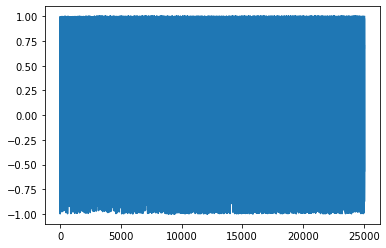

In [122]:
import matplotlib.pyplot as plt
plt.plot(articles['vader_compound'].tolist())

**Update Vadar + LM + HL**

In [132]:
import os
positive_words = []

with open('hu_positive_words.txt', 'r') as f:
    positive_words = [line.strip() for line in f]
    f.close()
    
positive_words = positive_words[35:]
positive_words[:5]

['a+', 'abound', 'abounds', 'abundance', 'abundant']

In [133]:
negative_words = []

with open('hu_negative_words.txt', 'r') as f:
    negative_words = [line.strip() for line in f]
    f.close()
    
negative_words = negative_words[35:]
negative_words[:5]

['2-faced', '2-faces', 'abnormal', 'abolish', 'abominable']

In [134]:
for w in positive_words:
    new_words[w.lower()] = 1

for w in negative_words:
    new_words[w.lower()] = -1    

In [135]:
sia = SentimentIntensityAnalyzer()

sia.lexicon.update(new_words)

In [136]:
def sentiment_add(tokens):
    text = " ".join(tokens)
    return sia.polarity_scores(text)

articles['vadar_LM_HL_scores'] = articles["token"].apply(sentiment_add)

In [137]:
articles.head()

,Year,Month,Title,Text,Keywords,afinn_score,vader_positive,Vader_negative,vader_neutral,vader_compound,token,vadar_LM_scores,vader_LM_positive,vader_LM_negative,vader_LM_neutral,vader_LM_compound,vadar_LM_HU_scores
3,2002,1,Coal ministry may extend verification deadline,the union coal ministry on tuesday said it was...,"['governments', 'failed', 'coal', 'noncore', '...",-6.0,0.070,0.081,0.849,-0.6898,"[union, coal, ministry, tuesday, said, likely,...","{'neg': 0.135, 'neu': 0.764, 'pos': 0.101, 'co...",0.101,0.135,0.764,-0.5574,"{'neg': 0.133, 'neu': 0.734, 'pos': 0.133, 'co..."
4,2002,1,What 2002 has in store for India Inc,yashwant sinha harping on a 7 per cent growth ...,"['sector', 'companies', 'store', 'cii', 'expec...",49.0,0.104,0.037,0.858,0.9951,"[yashwant, sinha, harping, per, cent, growth, ...","{'neg': 0.076, 'neu': 0.698, 'pos': 0.226, 'co...",0.226,0.076,0.698,0.9973,"{'neg': 0.082, 'neu': 0.677, 'pos': 0.241, 'co..."
5,2002,1,Year to the ground,"6 jan: enron threatens to invoke lcs, guarante...","['dec', 'bank', 'ground', 'sept', 'jan', 'nov'...",-51.0,0.081,0.136,0.783,-0.9987,"[jan, enron, threatens, invoke, lcs, guarantee...","{'neg': 0.188, 'neu': 0.72, 'pos': 0.093, 'com...",0.093,0.188,0.720,-0.9989,"{'neg': 0.199, 'neu': 0.709, 'pos': 0.092, 'co..."
6,2002,1,EoIs for third tranche of ITDC hotels,the government on tuesday invited initial bids...,"['sale', 'itdc', 'tranche', 'eois', 'propertie...",-1.0,0.014,0.027,0.959,-0.5859,"[government, tuesday, invited, initial, bid, t...","{'neg': 0.046, 'neu': 0.93, 'pos': 0.024, 'com...",0.024,0.046,0.930,-0.5859,"{'neg': 0.046, 'neu': 0.914, 'pos': 0.04, 'com..."
7,2002,1,Two-year transition period proposed after APM,the government has proposed a transition perio...,"['twoyear', 'sector', 'petroleum', 'system', '...",10.0,0.061,0.009,0.930,0.9643,"[government, proposed, transition, period, two...","{'neg': 0.017, 'neu': 0.864, 'pos': 0.119, 'co...",0.119,0.017,0.864,0.9808,"{'neg': 0.036, 'neu': 0.841, 'pos': 0.123, 'co..."


In [138]:
def type_pos(score):
    return score["pos"]

def type_neg(score):
    return score["neg"]

def type_neu(score):
    return score["neu"]

def type_comp(score):
    return score["compound"]

articles["vader_LM_HL_positive"] = articles["vadar_LM_HL_scores"].apply(type_pos)

articles["vader_LM_HL_negative"] = articles["vadar_LM_HL_scores"].apply(type_neg)

articles["vader_LM_HL_neutral"] = articles["vadar_LM_HL_scores"].apply(type_neu)

articles["vader_LM_HL_compound"] = articles["vadar_LM_HL_scores"].apply(type_comp)

In [140]:
articles.head()

,Year,Month,Title,Text,Keywords,afinn_score,vader_positive,Vader_negative,vader_neutral,vader_compound,...,vadar_LM_scores,vader_LM_positive,vader_LM_negative,vader_LM_neutral,vader_LM_compound,vadar_LM_HU_scores,vader_LM_HU_positive,vader_LM_HU_negative,vader_LM_HU_neutral,vader_LM_HU_compound
3,2002,1,Coal ministry may extend verification deadline,the union coal ministry on tuesday said it was...,"['governments', 'failed', 'coal', 'noncore', '...",-6.0,0.070,0.081,0.849,-0.6898,...,"{'neg': 0.135, 'neu': 0.764, 'pos': 0.101, 'co...",0.101,0.135,0.764,-0.5574,"{'neg': 0.133, 'neu': 0.734, 'pos': 0.133, 'co...",0.133,0.133,0.734,-0.0258
4,2002,1,What 2002 has in store for India Inc,yashwant sinha harping on a 7 per cent growth ...,"['sector', 'companies', 'store', 'cii', 'expec...",49.0,0.104,0.037,0.858,0.9951,...,"{'neg': 0.076, 'neu': 0.698, 'pos': 0.226, 'co...",0.226,0.076,0.698,0.9973,"{'neg': 0.082, 'neu': 0.677, 'pos': 0.241, 'co...",0.241,0.082,0.677,0.9976
5,2002,1,Year to the ground,"6 jan: enron threatens to invoke lcs, guarante...","['dec', 'bank', 'ground', 'sept', 'jan', 'nov'...",-51.0,0.081,0.136,0.783,-0.9987,...,"{'neg': 0.188, 'neu': 0.72, 'pos': 0.093, 'com...",0.093,0.188,0.720,-0.9989,"{'neg': 0.199, 'neu': 0.709, 'pos': 0.092, 'co...",0.092,0.199,0.709,-0.9987
6,2002,1,EoIs for third tranche of ITDC hotels,the government on tuesday invited initial bids...,"['sale', 'itdc', 'tranche', 'eois', 'propertie...",-1.0,0.014,0.027,0.959,-0.5859,...,"{'neg': 0.046, 'neu': 0.93, 'pos': 0.024, 'com...",0.024,0.046,0.930,-0.5859,"{'neg': 0.046, 'neu': 0.914, 'pos': 0.04, 'com...",0.040,0.046,0.914,-0.4019
7,2002,1,Two-year transition period proposed after APM,the government has proposed a transition perio...,"['twoyear', 'sector', 'petroleum', 'system', '...",10.0,0.061,0.009,0.930,0.9643,...,"{'neg': 0.017, 'neu': 0.864, 'pos': 0.119, 'co...",0.119,0.017,0.864,0.9808,"{'neg': 0.036, 'neu': 0.841, 'pos': 0.123, 'co...",0.123,0.036,0.841,0.9723


In [141]:
articles.to_csv("supervised_text.csv")

In [6]:
import pandas as pd
df = pd.read_csv("supervised_text.csv", index_col = None)

df.head()

,Unnamed: 0,Year,Month,Title,Text,Keywords,afinn_score,vader_positive,Vader_negative,vader_neutral,...,vadar_LM_scores,vader_LM_positive,vader_LM_negative,vader_LM_neutral,vader_LM_compound,vadar_LM_HU_scores,vader_LM_HU_positive,vader_LM_HU_negative,vader_LM_HU_neutral,vader_LM_HU_compound
0,3,2002,1,Coal ministry may extend verification deadline,the union coal ministry on tuesday said it was...,"['governments', 'failed', 'coal', 'noncore', '...",-6.0,0.070,0.081,0.849,...,"{'neg': 0.135, 'neu': 0.764, 'pos': 0.101, 'co...",0.101,0.135,0.764,-0.5574,"{'neg': 0.133, 'neu': 0.734, 'pos': 0.133, 'co...",0.133,0.133,0.734,-0.0258
1,4,2002,1,What 2002 has in store for India Inc,yashwant sinha harping on a 7 per cent growth ...,"['sector', 'companies', 'store', 'cii', 'expec...",49.0,0.104,0.037,0.858,...,"{'neg': 0.076, 'neu': 0.698, 'pos': 0.226, 'co...",0.226,0.076,0.698,0.9973,"{'neg': 0.082, 'neu': 0.677, 'pos': 0.241, 'co...",0.241,0.082,0.677,0.9976
2,5,2002,1,Year to the ground,"6 jan: enron threatens to invoke lcs, guarante...","['dec', 'bank', 'ground', 'sept', 'jan', 'nov'...",-51.0,0.081,0.136,0.783,...,"{'neg': 0.188, 'neu': 0.72, 'pos': 0.093, 'com...",0.093,0.188,0.720,-0.9989,"{'neg': 0.199, 'neu': 0.709, 'pos': 0.092, 'co...",0.092,0.199,0.709,-0.9987
3,6,2002,1,EoIs for third tranche of ITDC hotels,the government on tuesday invited initial bids...,"['sale', 'itdc', 'tranche', 'eois', 'propertie...",-1.0,0.014,0.027,0.959,...,"{'neg': 0.046, 'neu': 0.93, 'pos': 0.024, 'com...",0.024,0.046,0.930,-0.5859,"{'neg': 0.046, 'neu': 0.914, 'pos': 0.04, 'com...",0.040,0.046,0.914,-0.4019
4,7,2002,1,Two-year transition period proposed after APM,the government has proposed a transition perio...,"['twoyear', 'sector', 'petroleum', 'system', '...",10.0,0.061,0.009,0.930,...,"{'neg': 0.017, 'neu': 0.864, 'pos': 0.119, 'co...",0.119,0.017,0.864,0.9808,"{'neg': 0.036, 'neu': 0.841, 'pos': 0.123, 'co...",0.123,0.036,0.841,0.9723


In [2]:
import seaborn as sns

df.columns

Index(['Unnamed: 0', 'Year', 'Month', 'Title', 'Text', 'Keywords',
       'afinn_score', 'vader_positive', 'Vader_negative', 'vader_neutral',
       'vader_compound', 'token', 'vadar_LM_scores', 'vader_LM_positive',
       'vader_LM_negative', 'vader_LM_neutral', 'vader_LM_compound',
       'vadar_LM_HU_scores', 'vader_LM_HU_positive', 'vader_LM_HU_negative',
       'vader_LM_HU_neutral', 'vader_LM_HU_compound'],
      dtype='object')

In [3]:
vader_values = df["vader_compound"].to_list()
afin_values = df["afinn_score"].to_list()

In [4]:
df["vader_LM_HL_compound"].describe()

count    25070.000000
mean         0.582424
std          0.617014
min         -0.999100
25%          0.493900
50%          0.908100
75%          0.973800
max          1.000000
Name: vader_LM_HU_compound, dtype: float64

In [5]:
compund_scores_df = df[["vader_compound", "afinn_score", "vader_LM_compound", "vader_LM_HL_compound"]]

positive_scores_df = df[["vader_positive", "afinn_score", "vader_LM_positive", "vader_LM_HL_positive"]]

negative_scores_df = df[["Vader_negative", "afinn_score", "vader_LM_negative", "vader_LM_HL_negative"]]

neutral_scores_df = df[["vader_neutral", "afinn_score", "vader_LM_neutral", "vader_LM_HL_neutral"]]

df.head()


,Unnamed: 0,Year,Month,Title,Text,Keywords,afinn_score,vader_positive,Vader_negative,vader_neutral,...,vadar_LM_scores,vader_LM_positive,vader_LM_negative,vader_LM_neutral,vader_LM_compound,vadar_LM_HU_scores,vader_LM_HU_positive,vader_LM_HU_negative,vader_LM_HU_neutral,vader_LM_HU_compound
0,3,2002,1,Coal ministry may extend verification deadline,the union coal ministry on tuesday said it was...,"['governments', 'failed', 'coal', 'noncore', '...",-6.0,0.070,0.081,0.849,...,"{'neg': 0.135, 'neu': 0.764, 'pos': 0.101, 'co...",0.101,0.135,0.764,-0.5574,"{'neg': 0.133, 'neu': 0.734, 'pos': 0.133, 'co...",0.133,0.133,0.734,-0.0258
1,4,2002,1,What 2002 has in store for India Inc,yashwant sinha harping on a 7 per cent growth ...,"['sector', 'companies', 'store', 'cii', 'expec...",49.0,0.104,0.037,0.858,...,"{'neg': 0.076, 'neu': 0.698, 'pos': 0.226, 'co...",0.226,0.076,0.698,0.9973,"{'neg': 0.082, 'neu': 0.677, 'pos': 0.241, 'co...",0.241,0.082,0.677,0.9976
2,5,2002,1,Year to the ground,"6 jan: enron threatens to invoke lcs, guarante...","['dec', 'bank', 'ground', 'sept', 'jan', 'nov'...",-51.0,0.081,0.136,0.783,...,"{'neg': 0.188, 'neu': 0.72, 'pos': 0.093, 'com...",0.093,0.188,0.720,-0.9989,"{'neg': 0.199, 'neu': 0.709, 'pos': 0.092, 'co...",0.092,0.199,0.709,-0.9987
3,6,2002,1,EoIs for third tranche of ITDC hotels,the government on tuesday invited initial bids...,"['sale', 'itdc', 'tranche', 'eois', 'propertie...",-1.0,0.014,0.027,0.959,...,"{'neg': 0.046, 'neu': 0.93, 'pos': 0.024, 'com...",0.024,0.046,0.930,-0.5859,"{'neg': 0.046, 'neu': 0.914, 'pos': 0.04, 'com...",0.040,0.046,0.914,-0.4019
4,7,2002,1,Two-year transition period proposed after APM,the government has proposed a transition perio...,"['twoyear', 'sector', 'petroleum', 'system', '...",10.0,0.061,0.009,0.930,...,"{'neg': 0.017, 'neu': 0.864, 'pos': 0.119, 'co...",0.119,0.017,0.864,0.9808,"{'neg': 0.036, 'neu': 0.841, 'pos': 0.123, 'co...",0.123,0.036,0.841,0.9723


In [6]:
# from sklearn.preprocessing import StandardScaler

# scores_df['afinn_standardized'] = 0
# scores_df[['afinn_standardized']] = StandardScaler().fit_transform(scores_df[['afinn_score']])

# scores_df.head()
df.columns

Index(['Unnamed: 0', 'Year', 'Month', 'Title', 'Text', 'Keywords',
       'afinn_score', 'vader_positive', 'Vader_negative', 'vader_neutral',
       'vader_compound', 'token', 'vadar_LM_scores', 'vader_LM_positive',
       'vader_LM_negative', 'vader_LM_neutral', 'vader_LM_compound',
       'vadar_LM_HU_scores', 'vader_LM_HU_positive', 'vader_LM_HU_negative',
       'vader_LM_HU_neutral', 'vader_LM_HU_compound'],
      dtype='object')

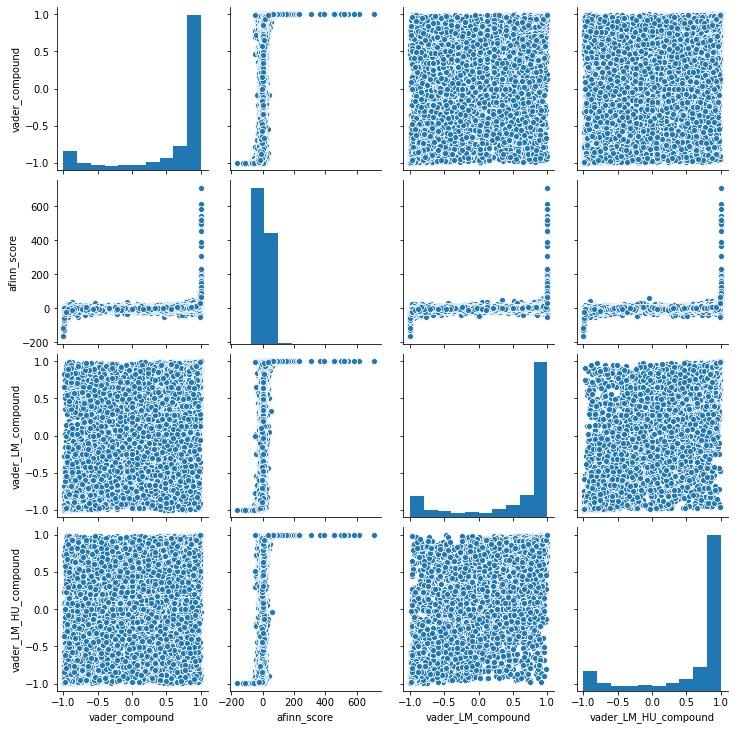

In [7]:
sns.pairplot(compund_scores_df)

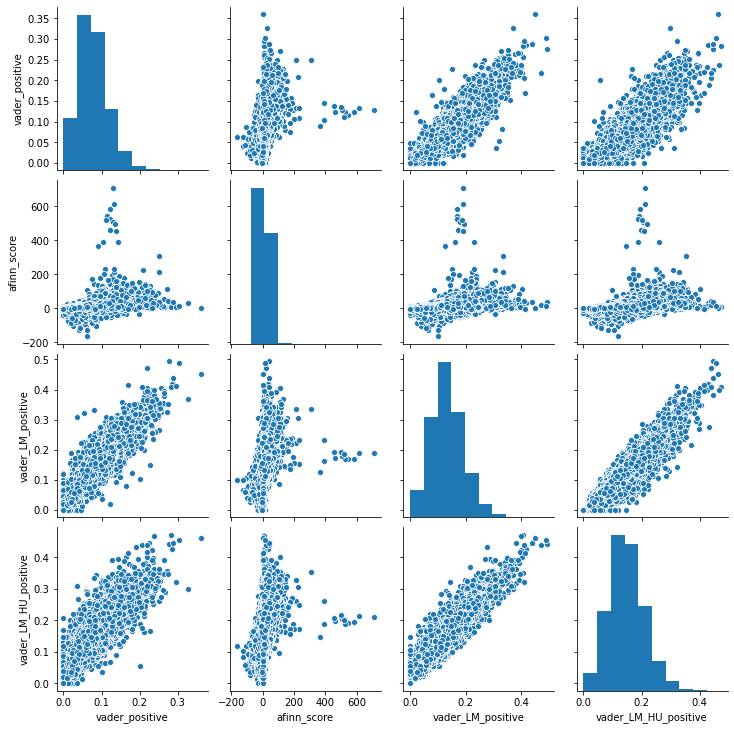

In [8]:
sns.pairplot(positive_scores_df)

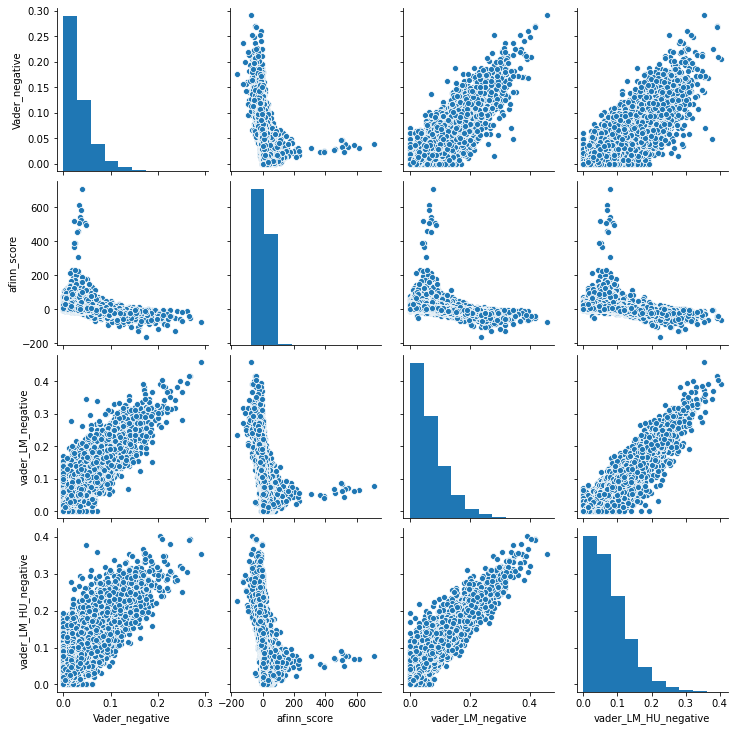

In [9]:
sns.pairplot(negative_scores_df)

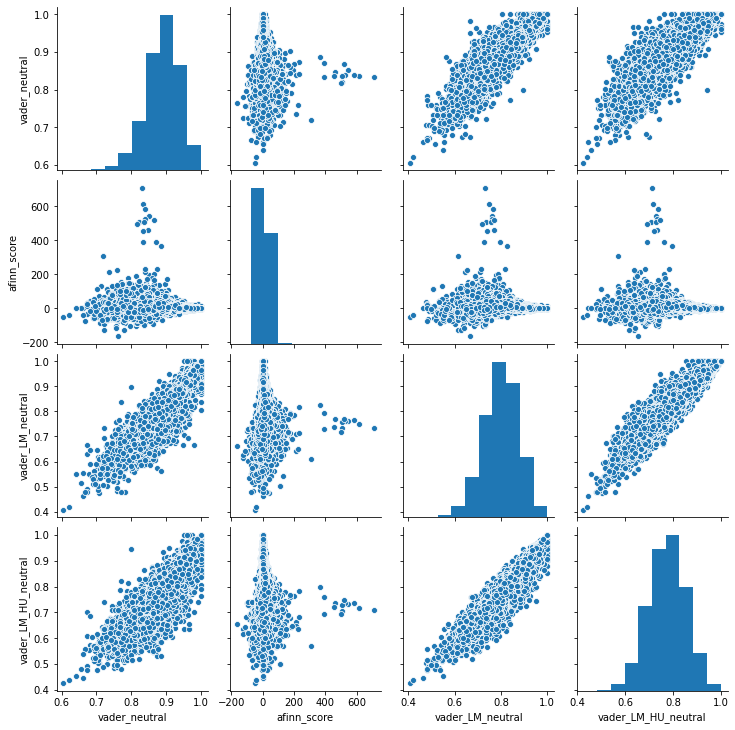

In [10]:
sns.pairplot(neutral_scores_df)

In [50]:
from sklearn.preprocessing import MinMaxScaler

df['afinn_standardized'] = 0
df[['afinn_standardized']] = MinMaxScaler().fit_transform(df[['afinn_score']])

df['vader_LM_compound_standardizd'] = 0
df[['vader_LM_compound_standardizd']] = MinMaxScaler().fit_transform(df[['vader_LM_compound']])

df['vader_LM_HL_compound_standardizd'] = 0
df[['vader_LM_HL_compound_standardizd']] = MinMaxScaler().fit_transform(df[['vader_LM_HL_compound']])

df.head()

,Unnamed: 0,Year,Month,Title,Text,Keywords,afinn_score,vader_positive,Vader_negative,vader_neutral,...,vader_LM_neutral,vader_LM_compound,vadar_LM_HU_scores,vader_LM_HU_positive,vader_LM_HU_negative,vader_LM_HU_neutral,vader_LM_HU_compound,afinn_standardized,vader_LM_compound_standardizd,vader_LM_HL_compound_standardizd
0,3,2002,1,Coal ministry may extend verification deadline,the union coal ministry on tuesday said it was...,"['governments', 'failed', 'coal', 'noncore', '...",-6.0,0.070,0.081,0.849,...,0.764,-0.5574,"{'neg': 0.133, 'neu': 0.734, 'pos': 0.133, 'co...",0.133,0.133,0.734,-0.0258,0.181922,0.221105,0.486869
1,4,2002,1,What 2002 has in store for India Inc,yashwant sinha harping on a 7 per cent growth ...,"['sector', 'companies', 'store', 'cii', 'expec...",49.0,0.104,0.037,0.858,...,0.698,0.9973,"{'neg': 0.082, 'neu': 0.677, 'pos': 0.241, 'co...",0.241,0.082,0.677,0.9976,0.244851,0.998650,0.998799
2,5,2002,1,Year to the ground,"6 jan: enron threatens to invoke lcs, guarante...","['dec', 'bank', 'ground', 'sept', 'jan', 'nov'...",-51.0,0.081,0.136,0.783,...,0.720,-0.9989,"{'neg': 0.199, 'neu': 0.709, 'pos': 0.092, 'co...",0.092,0.199,0.709,-0.9987,0.130435,0.000300,0.000200
3,6,2002,1,EoIs for third tranche of ITDC hotels,the government on tuesday invited initial bids...,"['sale', 'itdc', 'tranche', 'eois', 'propertie...",-1.0,0.014,0.027,0.959,...,0.930,-0.5859,"{'neg': 0.046, 'neu': 0.914, 'pos': 0.04, 'com...",0.040,0.046,0.914,-0.4019,0.187643,0.206852,0.298734
4,7,2002,1,Two-year transition period proposed after APM,the government has proposed a transition perio...,"['twoyear', 'sector', 'petroleum', 'system', '...",10.0,0.061,0.009,0.930,...,0.864,0.9808,"{'neg': 0.036, 'neu': 0.841, 'pos': 0.123, 'co...",0.123,0.036,0.841,0.9723,0.200229,0.990398,0.986144


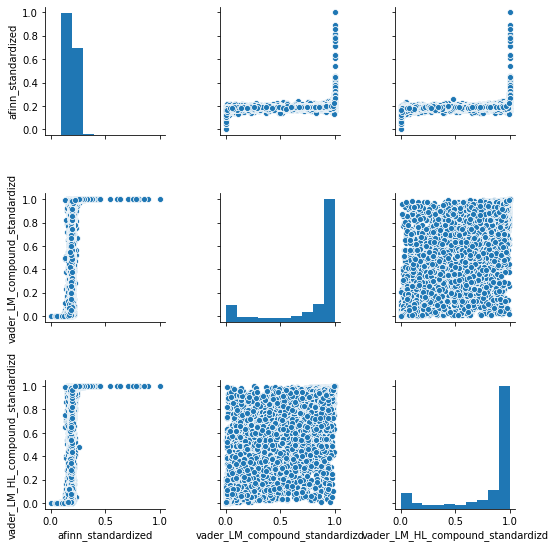

In [51]:
compound_scores_df = df[["afinn_standardized", "vader_LM_compound_standardizd", "vader_LM_HL_compound_standardizd"]]
sns.pairplot(compound_scores_df)

(array([ 2056.,   758.,   538.,   514.,   574.,   487.,   835.,  1192.,
         2395., 15721.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

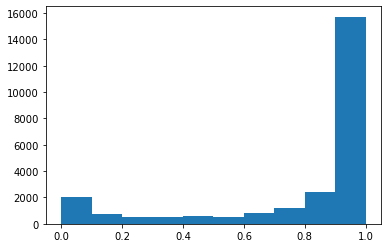

In [53]:
import matplotlib.pyplot as plt
plt.hist(df['vader_LM_HL_compound_standardizd'].to_list())

In [55]:
df.columns

Index(['Unnamed: 0', 'Year', 'Month', 'Title', 'Text', 'Keywords',
       'afinn_score', 'vader_positive', 'Vader_negative', 'vader_neutral',
       'vader_compound', 'token', 'vadar_LM_scores', 'vader_LM_positive',
       'vader_LM_negative', 'vader_LM_neutral', 'vader_LM_compound',
       'vadar_LM_HU_scores', 'vader_LM_HU_positive', 'vader_LM_HU_negative',
       'vader_LM_HU_neutral', 'vader_LM_HU_compound', 'afinn_standardized',
       'vader_LM_compound_standardizd', 'vader_LM_HL_compound_standardizd'],
      dtype='object')

(array([ 2056.,   758.,   538.,   514.,   574.,   487.,   835.,  1192.,
         2395., 15721.]),
 array([-9.9910e-01, -7.9919e-01, -5.9928e-01, -3.9937e-01, -1.9946e-01,
         4.5000e-04,  2.0036e-01,  4.0027e-01,  6.0018e-01,  8.0009e-01,
         1.0000e+00]),
 <a list of 10 Patch objects>)

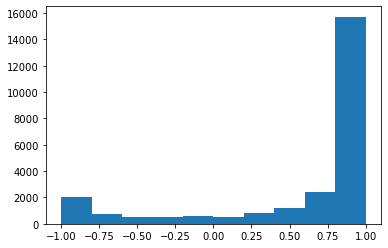

In [56]:
import matplotlib.pyplot as plt
plt.hist(df['vader_LM_HL_compound'].to_list())

## Results of all dictionaries

### i) afinn

In [28]:
def find_top_texts(df, column_name, ascending):
    if ascending == True:
        df = df.sort_values(column_name, ascending=True)
        text = df.iloc[0:10, 4].to_list()
    else:
        df = df.sort_values(column_name, ascending=False)
        text = df.iloc[0:10, 4].to_list()
        
    return text

In [29]:
afinn_score_pos_text = find_top_texts(df, "afinn_score", False)
afinn_score_neg_text = find_top_texts(df, "afinn_score", True)

In [47]:
afinn_score_neg_text[0]

'As the popular game maker Rockstar Games forthcoming title Bully faces resistance and criticism from parents and critics worldwide, the issue once again brings to the fore the controversies that have been courting popular game titles. Video game makers have often found themselves in the line of fire for depiction of graphic violence, sexual themes, advertising, consumption of illegal drugs, alcohol or tobacco, propaganda and profanity.While most gaming aficionados would have heard about games like Doom, Mortal Kombat, Grand Theft Auto and Manhunt, not many know the controversies that these games raked in several countries due to their \'disparaging\' content. Here\'s a look into the controversies from the gaming world.Death RacePublisher: Exidy, 1976Death Race is an arcade game based on the movie Death Race 2000, starring David Carradine and Sylvester Stallone. The movie\'s tagline, "In the year 2000, hit and run driving is no longer a felony. It\'s the national sport!" rang true of t

In [46]:
afinn_score_pos_text[1]

'The world economy witnessed a sharp upturn in 2004, on account of robust growth in both advanced and emerging market economies. Global output is projected to grow by 5 per cent in 2004, the highest in nearly three decades. Economic activity rebounded strongly in advanced economies with the growth impetus emanating from upbeat performances by the United States (US) and Japan.Among emerging market economies, the Commonwealth of Independent States (CIS) and developing Asia continued to add stability to the overall process of global expansion and consolidation (Table 6.1). 6.2 The US economy was once again the prime determinant of global growth among the G-3 (US, Japan and the Euro area), despite indications of a slight slowdown during the later part of 2004.A similar trend was witnessed in Japan, which is projected to improve output growth by nearly 2 percentage points over 2003. Indications of a broad-based recovery were evident in the Euro area as well, on account of strong growth in t

### ii) Vader

In [34]:
vader_score_pos_text = find_top_texts(df, "vader_compound", False)
vader_score_neg_text = find_top_texts(df, "vader_compound", True)

In [35]:
vader_score_neg_text[0]

'As the popular game maker Rockstar Games forthcoming title Bully faces resistance and criticism from parents and critics worldwide, the issue once again brings to the fore the controversies that have been courting popular game titles. Video game makers have often found themselves in the line of fire for depiction of graphic violence, sexual themes, advertising, consumption of illegal drugs, alcohol or tobacco, propaganda and profanity.While most gaming aficionados would have heard about games like Doom, Mortal Kombat, Grand Theft Auto and Manhunt, not many know the controversies that these games raked in several countries due to their \'disparaging\' content. Here\'s a look into the controversies from the gaming world.Death RacePublisher: Exidy, 1976Death Race is an arcade game based on the movie Death Race 2000, starring David Carradine and Sylvester Stallone. The movie\'s tagline, "In the year 2000, hit and run driving is no longer a felony. It\'s the national sport!" rang true of t

In [36]:
vader_score_pos_text[0]

'Speech of P Chidambaram, Minister of FinanceMr. Speaker, SirIt is my privilege to present the Budget for the year 2006-07.An overview of the economy2. Twenty months ago, when I presented the first Budget of the UPA Government, I asked Honourable Members ��� and the people of this country ��� to walk with us on the path of honour and courage.The final report card on the first year of the UPA Government is out, and there are reasons to celebrate. According to the Central Statistical Organization (CSO), the growth rate in 2004-05 was 7.5 per cent, with the manufacturing sector growing at 8.1 per cent. More importantly, at current market prices, gross domestic saving increased to 29.1 per cent of GDP and the rate of gross capital formation increased to 30.1 per cent of GDP.I have no doubt in my mind that these results were due to the political message conveyed by the National Common Minimum Programme (NCMP); the perceptive leadership of the Prime Minister, Dr. Manmohan Singh; the policy c

### iii) vader_LM_compound

In [37]:
vader_LM_score_pos_text = find_top_texts(df, "vader_LM_compound", False)
vader_LM_score_neg_text = find_top_texts(df, "vader_LM_compound", True)

In [38]:
vader_LM_score_neg_text[0]

'As the popular game maker Rockstar Games forthcoming title Bully faces resistance and criticism from parents and critics worldwide, the issue once again brings to the fore the controversies that have been courting popular game titles. Video game makers have often found themselves in the line of fire for depiction of graphic violence, sexual themes, advertising, consumption of illegal drugs, alcohol or tobacco, propaganda and profanity.While most gaming aficionados would have heard about games like Doom, Mortal Kombat, Grand Theft Auto and Manhunt, not many know the controversies that these games raked in several countries due to their \'disparaging\' content. Here\'s a look into the controversies from the gaming world.Death RacePublisher: Exidy, 1976Death Race is an arcade game based on the movie Death Race 2000, starring David Carradine and Sylvester Stallone. The movie\'s tagline, "In the year 2000, hit and run driving is no longer a felony. It\'s the national sport!" rang true of t

In [39]:
vader_LM_score_pos_text[0]

'OverviewThe year 2004-05 started on a positive note in April 2004 with annual growth of 8.9 per cent in the Index of Industrial Production (IIP). The deceleration in growth observed in May was quickly reversed, and IIP growth gained momentum until October and declined only marginally in November but revived again in December. During October, the IIP registered the highest growth (10.1 per cent) since November 1997.The current year conforms to the normal historic pattern of industrial buoyancy following a good agricultural year. Industrial growth of 8.4 per cent during April â€“ December 2004-05 is the highest after 1995-96. Robust growth of 9.0 per cent in manufacturing â€“ a sector with a weight of 79.4 per cent in IIP â€“ in the first three quarters of the current year not only came in succession to the high growth in the two previous years, but also contributed significantly to the satisfactory performance of IIP overall (Table 7.1 and figures 7.1 & 7.2). In April-December 2004, mi

### iv) vader + LM + HU

In [41]:
vader_LM_HL_score_pos_text = find_top_texts(df, "vader_LM_HL_compound", False)
vader_LM_HL_score_neg_text = find_top_texts(df, "vader_LM_HL_compound", True)

In [42]:
vader_LM_HL_score_neg_text[0]

'MUMBAI: Holding that Bollywood actor Sanjay Dutt was not a terrorist, a court on Tuesday acquitted him of the serious charge of conspiracy in the 1993 serial blasts here but convicted him of the lesser crime of possessing arms that carries a maximum prison term of three years."During my reasoning I have not found him (Sanjay) to be a terrorist," Judge P D Kode of the TADA court said as the star of theMunnabhaiseries pensively awaited the verdict.Accepting 47-year-old Sanjay\'s confession, Kode observed: "Considering matters in his confession and also taking into account certain admissions from other evidence, I accept the stand of Sanjay of acquiring and possessing weapons for self- defence."Sanjay, who spent about 16 months in prison after his arrest in April 1993, was found guilty under Sections 3 and 7 read with Section 25 of the Indian Arms Act. Under Section 3, he was found guilty of possessing a 9mm pistol and under Section 7 for possessing an AK-56 rifle, a prohibited weapon.Un

In [43]:
vader_LM_HL_score_pos_text[0]

'Statement By Y Venugopal Reddy, Governor, Reserve Bank Of India OnMid-Term Review Of Annual PolicyFor The Year â€™04-05The policy documents of the Reserve Bank capture the rationale of monetary, structural and prudential measures introduced from time to time against the background of an assessment of macroeconomic and monetary developments. In the process, the approach of greater transparency and better communication contributes towards an effective consultation process in policy making.This Statement on Mid-term Review of the Annual Policy for the year â€™04-05 follows the pattern already set in the previous years. It consists of three parts: (I) Mid-term Review of Macroeconomic and Monetary Developments in â€˜04-05; (II) Stance of Monetary Policy for the Second Half of â€˜04-05; and (III) Financial Sector Reforms and Monetary Policy Measures.(Editorâ€™s Note: Due to space constraints, we have dropped the Annexures plus certain sections of Part I, which deals with the Mid-term Review